# viz

> vizualization routines


**NOTE:** Lazy imports throughout

In [1]:
#| default_exp viz

In [2]:
#| hide
from nbdev.showdoc import *


In [3]:
#| export
import torch
import numpy as np
import wandb
import gc
from torchvision.utils import make_grid

## UMAP

In [4]:
#| export
def cpu_umap_project(embeddings, n_components=3, n_neighbors=15, min_dist=0.1, random_state=42):
    "Project embeddings to n_components dimensions via UMAP (on CPU)"
    import umap
    if isinstance(embeddings, torch.Tensor): embeddings = embeddings.detach().cpu().numpy()
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    return reducer.fit_transform(embeddings)

In [5]:
#| export
def cuml_umap_project(embeddings, n_components=3, n_neighbors=15, min_dist=0.1, random_state=42):
    "Project embeddings to n_components dimensions via cuML UMAP (GPU)"
    from cuml import UMAP
    import cupy as cp
    if isinstance(embeddings, torch.Tensor): embeddings = cp.from_dlpack(embeddings.detach())
    reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    coords = reducer.fit_transform(embeddings)
    del reducer
    return cp.asnumpy(coords)  # back to numpy for plotly

In [6]:
#| export
def umap_project(embeddings, **kwargs): 
    "Calls one of two preceding UMAP routines based on device availability."
    if embeddings.is_cuda:
        try: return cuml_umap_project(embeddings, **kwargs)
        except torch.cuda.OutOfMemoryError:
            torch.cuda.empty_cache()
            return cpu_umap_project(embeddings, **kwargs)
    return cpu_umap_project(embeddings, **kwargs)

## PCA

In [7]:
#| export
def cuml_pca_project(embeddings, n_components=3):
    "Project embeddings to n_components dimensions via cuML PCA (GPU)"
    from cuml import PCA
    import cupy as cp
    if isinstance(embeddings, torch.Tensor): embeddings = cp.from_dlpack(embeddings.detach())
    coords = PCA(n_components=n_components).fit_transform(embeddings)
    return cp.asnumpy(coords)

In [8]:
#| export
def cpu_pca_project(embeddings, n_components=3):
    "Project embeddings to n_components dimensions via sklearn PCA (CPU)"
    from sklearn.decomposition import PCA
    if isinstance(embeddings, torch.Tensor): embeddings = embeddings.detach().cpu().numpy()
    return PCA(n_components=n_components).fit_transform(embeddings)

In [9]:
#| export
def pca_project(embeddings, **kwargs):
    "Calls GPU or CPU PCA based on availability"
    if embeddings.is_cuda:
        try: return cuml_pca_project(embeddings, **kwargs)
        except: return cpu_pca_project(embeddings, **kwargs)
    return cpu_pca_project(embeddings, **kwargs)

## 3D Plotly Scatterplots

In [10]:
#| export
@torch.no_grad()
def plot_embeddings_3d(coords, num_tokens, color_by='pairs', file_idx=None, deltas=None, title='Embeddings', debug=False):
    "3D scatter plot of embeddings. color_by: 'none', 'file', or 'pair'"
    import plotly.graph_objects as go
    n = len(coords)
    if debug: print(" plot_embeddings_3d: n =",n)
    
    if color_by == 'none':     colors = ['blue'] * n
    elif color_by == 'file':   colors = file_idx.tolist() if file_idx is not None else ['blue'] * n
    elif color_by == 'pairs':
        n_pairs = n // 2
        pair_colors = [f'rgb({np.random.randint(0,256)},{np.random.randint(0,256)},{np.random.randint(0,256)})' for _ in range(n_pairs)]
        colors = [pair_colors[i % n_pairs] for i in range(n)]  # pairs separated by num_tokens 
    else: raise ValueError(f"Unknown color_by: {color_by}")

    hover_text = [f"file_id: {int(fid)}, deltas: {ds.cpu().numpy()}" for fid, ds in zip(file_idx,deltas)] if (file_idx is not None) and (deltas is not None) else None
    if color_by == 'pairs':
        hover_text = [f"pair {i%n_pairs}" for i in range(n)] if hover_text is None else [f"{s}, pair {i%n_pairs}" for i, s in enumerate(hover_text)]

    
    fig = go.Figure(data=[go.Scatter3d(
        x=coords[:,0], y=coords[:,1], z=coords[:,2],
        mode='markers', 
        marker=dict(size=4, color=colors, colorscale='Viridis' if color_by != 'pairs' else None, opacity=0.8),
        hovertext=hover_text, hoverinfo='x+y+z+text' if hover_text else 'x+y+z'
    )])
    title = title + f', n={n}'
    fig.update_layout(title=title, margin=dict(l=0, r=0, b=0, t=30))
    return fig


## Main Routine 

Calls the preceding routines

In [11]:
#| export
@torch.no_grad()
def _make_emb_viz(zs, num_tokens, epoch=-1, title='Embeddings', do_umap=True, file_idx=None, deltas=None):
    "visualize embeddings, projected"
    umap_fig = None
    if do_umap:
        coords = umap_project(zs)
        umap_fig = plot_embeddings_3d(coords, num_tokens, title=title+f' (UMAP), epoch {epoch}', file_idx=file_idx, deltas=deltas)
    if torch.cuda.is_available(): torch.cuda.synchronize() # cleanup before PCA or else you get CUDA errors
    gc.collect()
    coords = pca_project(zs)
    pca_fig = plot_embeddings_3d(coords, num_tokens, title=title+f' (PCA), epoch {epoch}', file_idx=file_idx, deltas=deltas)
    if wandb.run is not None: 
        if do_umap:
            wandb.log({f"{title} UMAP": wandb.Html(umap_fig.to_html()), f"{title} PCA": wandb.Html(pca_fig.to_html())})
        else:
            wandb.log({f"{title} PCA": wandb.Html(pca_fig.to_html())})
    if torch.cuda.is_available(): torch.cuda.synchronize() # cleanup again
    gc.collect()
    return pca_fig, umap_fig


In [12]:
#| export
def _subsample(data, indices, deltas, max_points, debug=False):
    "Subsample data and indices together, in pairs"
    perm1 = torch.randperm(len(data)//2)[:max_points//2]
    perm2 = perm1 + len(data)//2
    perm = torch.cat([perm1,perm2])
    return data[perm], indices[perm], deltas[perm]

Testing that:

In [13]:
#| eval: false
n_pairs, dim = 5, 1  # data points
z1 = 200*torch.arange(n_pairs).unsqueeze(-1).unsqueeze(-1)
z2 = z1 + 1 
zs = torch.cat([z1, z2], dim=0).view(-1, dim)
print("zs.shape = ",zs.shape)
indices = torch.arange(2*n_pairs)
deltas = torch.randint(0,12,(2*n_pairs, 2))
print("zs = \n",zs)
print("indices =",indices)
data_perm, indices2, deltas2 = _subsample(zs, indices, deltas, max_points=2*(n_pairs-2), debug=True)
print("data_perm.shape = ",data_perm.shape,", data_perm = \n",data_perm) 

zs.shape =  torch.Size([10, 1])
zs = 
 tensor([[  0],
        [200],
        [400],
        [600],
        [800],
        [  1],
        [201],
        [401],
        [601],
        [801]])
indices = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
data_perm.shape =  torch.Size([6, 1]) , data_perm = 
 tensor([[400],
        [800],
        [600],
        [401],
        [801],
        [601]])


Yes. That does what I expect. Moving on...

In [14]:
#| export
@torch.no_grad()
def make_emb_viz(enc_outs, epoch=-1, model=None, batch=None, title='Embeddings', max_points=5000, do_umap=True, debug=False):
    "this is the main viz routine, showing different groups of embeddings"
    device = enc_outs[0].patches[0].emb.device
    if model is not None: model.to('cpu')
    torch.cuda.empty_cache()

    num_patch_tokens = enc_outs[0].patches[-1].num_patches
    num_all_tokens = enc_outs[0].patches.all_emb.shape[1]  # CLS + patches # won't work on swin

    file_idx, deltas = None, None
    if batch is not None:
        file_idx = batch['file_idx'].repeat(2).repeat_interleave(num_patch_tokens).to(device)
        deltas = batch['deltas'].repeat(2, 1).repeat_interleave(num_patch_tokens, dim=0).to(device)

    # CLS tokens aka coarsest level
    cls_tokens = torch.cat((enc_outs[0].patches[0].emb, enc_outs[1].patches[0].emb), dim=0).squeeze(1)
    cls_file_idx = batch['file_idx'].repeat(2).to(device) if batch is not None else None
    cls_deltas = batch['deltas'].repeat(2, 1).to(device) if batch is not None else None
    cls_pca_fig, cls_umap_fig = _make_emb_viz(cls_tokens, num_all_tokens, epoch=epoch, title='CLS Tokens '+title, file_idx=cls_file_idx, deltas=cls_deltas, do_umap=do_umap)

    # Patches (non-CLS) aka finest level — already CLS-stripped via patches[-1]
    dim = enc_outs[0].patches[1].dim
    patches = torch.cat((enc_outs[0].patches[-1].emb, enc_outs[1].patches[-1].emb), dim=0).reshape(-1, dim)
    non_empty = (enc_outs[0].patches[1].non_empty & enc_outs[1].patches[-1].non_empty)
    valid = non_empty.flatten().repeat(2)

    # Non-empty patches
    valid_patches, valid_file_idx, valid_deltas = patches[valid], file_idx[valid], deltas[valid]
    rnd_patches, rnd_file_idx, rnd_deltas = _subsample(valid_patches, valid_file_idx, valid_deltas, max_points)
    patch_pca_fig, patch_umap_fig = _make_emb_viz(rnd_patches, num_all_tokens, epoch=epoch, title='RND Patches '+title, file_idx=rnd_file_idx, deltas=rnd_deltas, do_umap=do_umap)

    # plot when both patches are empty 
    ne1 = enc_outs[0].patches[-1].non_empty.flatten().repeat(2)
    ne2 = enc_outs[1].patches[-1].non_empty.flatten().repeat(2)
    both_empty = ~ne1 & ~ne2
    empty_patches, empty_file_idx, empty_deltas = patches[both_empty], file_idx[both_empty], deltas[both_empty]
    if debug: print("emtpy: patches[~both_empty].norm(dim=-1).mean() = ",patches[~both_empty].norm(dim=-1).mean())
    rnd_empty, rnd_empty_idx, rnd_empty_deltas = _subsample(empty_patches, empty_file_idx, empty_deltas, max_points)
    empty_pca_fig = _make_emb_viz(rnd_empty, num_all_tokens, epoch=epoch, title='RND Empty Patches '+title, do_umap=False, file_idx=rnd_empty_idx, deltas=rnd_empty_deltas)
    
    if model is not None: model.to(device)
    figs = {'cls_pca_fig':cls_pca_fig, 'cls_umap_fig':cls_umap_fig, 'patch_pca_fig':patch_pca_fig, 'patch_umap_fig':patch_umap_fig, 'empty_pca_fig': empty_pca_fig}
    return figs

Testing visualization:

In [15]:
#| eval: false
import plotly.io as pio
pio.renderers.default = 'notebook'
from midi_rae.core import PatchState, HierarchicalPatchState, EncoderOutput

bs, dim = 32, 256
num_patch = 64

# Build fake embeddings
z1_cls = torch.randn(bs, 1, dim)
z1_patch = torch.randn(bs, num_patch, dim)
z2_cls = z1_cls + 0.1 * torch.randn(bs, 1, dim)
z2_patch = z1_patch + 0.1 * torch.randn(bs, num_patch, dim)

# Positions and masks
cls_pos = torch.tensor([[-1, -1]])
patch_pos = torch.stack([torch.tensor([r, c]) for r in range(8) for c in range(8)])
mae_mask_cls = torch.ones(1, dtype=torch.bool)
mae_mask_patch = torch.ones(num_patch, dtype=torch.bool)

ne1 = torch.ones(bs, num_patch, dtype=torch.bool)
ne2 = torch.ones(bs, num_patch, dtype=torch.bool)
ne2[16:, :] = 0  # make half empty

enc_out1 = EncoderOutput(
    patches=HierarchicalPatchState(levels=[
        PatchState(emb=z1_cls, pos=cls_pos, non_empty=torch.ones(bs, 1, dtype=torch.bool), mae_mask=mae_mask_cls),
        PatchState(emb=z1_patch, pos=patch_pos, non_empty=ne1, mae_mask=mae_mask_patch),
    ]),
    full_pos=torch.cat([cls_pos, patch_pos]), full_non_empty=torch.cat([torch.ones(bs,1,dtype=torch.bool), ne1], dim=1),
    mae_mask=torch.cat([mae_mask_cls, mae_mask_patch]),
)
enc_out2 = EncoderOutput(
    patches=HierarchicalPatchState(levels=[
        PatchState(emb=z2_cls, pos=cls_pos, non_empty=torch.ones(bs, 1, dtype=torch.bool), mae_mask=mae_mask_cls),
        PatchState(emb=z2_patch, pos=patch_pos, non_empty=ne2, mae_mask=mae_mask_patch),
    ]),
    full_pos=torch.cat([cls_pos, patch_pos]), full_non_empty=torch.cat([torch.ones(bs,1,dtype=torch.bool), ne2], dim=1),
    mae_mask=torch.cat([mae_mask_cls, mae_mask_patch]),
)

batch = {'file_idx': torch.arange(bs), 'deltas': torch.randint(0, 12, (bs, 2))}

figs = make_emb_viz((enc_out1, enc_out2), title='testing', batch=batch, do_umap=False, debug=True)


emtpy: patches[~both_empty].norm(dim=-1).mean() =  tensor(16.0271)


ValueError: Found array with 0 sample(s) (shape=(0, 256)) while a minimum of 1 is required by PCA.

In [16]:
#| eval: false 
figs['patch_pca_fig'].show()

NameError: name 'figs' is not defined

## Reconstructions

In [17]:
#| export
def expand_patch_mask(mae_mask, grid_h, grid_w, patch_size):
    """Expand patch-level mask (N,) to pixel-level mask (H, W)"""
    return mae_mask.bool().reshape(grid_h, grid_w).repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)

In [18]:
#| export
def do_recon_eval(recon, real, mae_mask=None, patch_size=16, eps=1e-8): 
    "Evaluate recon accuracy, optionally only on masked patches"
    if mae_mask is not None: 
        B, C, H, W = real.shape
        grid_h, grid_w = H//patch_size, W//patch_size
        masked = ~expand_patch_mask(mae_mask, grid_h, grid_w, patch_size)
        recon, real = recon[:, :, masked], real[:, :, masked] 
    TP = (recon * real).sum()
    FP = (recon * (1 - real)).sum()
    FN = ((1 - recon) * real).sum()
    TN = ((1 - recon) * (1 - real)).sum()
    precision = TP / (TP + FP + eps) 
    recall = TP / (TP + FN + eps) 
    specificity = TN / (TN + FP + eps) 
    f1 = 2 * precision * recall / (precision + recall + eps) 
    evals = {'precision': precision, 'recall': recall, 'specificity': specificity, 'f1': f1}
    if wandb.run is not None: wandb.log(evals) 
    return evals 

In [19]:
#| export
def patches_to_img(recon_patches, img_real, patch_size=16, mae_mask=None): 
    "Convert image patches to full image. Copy over real patches where appropriate."
    B, C, H, W = img_real.shape
    grid_h, grid_w = H//patch_size, W//patch_size
    if recon_patches.shape[1] % 2 != 0: recon_patches = recon_patches[:,1:]  # strip cls token
    img_recon = recon_patches.reshape(B, grid_h, grid_w, patch_size, patch_size).permute(0, 1, 3, 2, 4)
    img_recon = img_recon.reshape(B, H, W).unsqueeze(1) 
    img_recon = torch.sigmoid(img_recon)
    img_recon = (img_recon > 0.25).float()
    if mae_mask is not None:
        vis_2d = expand_patch_mask(mae_mask, grid_h, grid_w, patch_size)
        img_recon[:, :, vis_2d] = img_real[:, :, vis_2d]
    return img_recon 

In [20]:
#| export
@torch.no_grad()
def viz_mae_recon(recon, img_real, enc_out=None, epoch=-1, patch_size=16):
    """Show how our LightweightMAEDecoder is doing (during encoder training)"""
    mae_mask = enc_out.mae_mask[1:] if enc_out is not None else None  # strip CLS
    recon, img_real = recon.cpu(), img_real.cpu()
    if mae_mask is not None: mae_mask = mae_mask.cpu()
    
    img_recon_noreplace = None 
    if recon.shape != img_real.shape:
        img_recon = patches_to_img(recon, img_real, patch_size=patch_size, mae_mask=mae_mask)
        img_recon_noreplace = patches_to_img(recon, img_real, patch_size=patch_size, mae_mask=None)
    else: 
        img_recon = (recon > 0.25).float()
    evals = do_recon_eval(img_recon, img_real, mae_mask=mae_mask, patch_size=patch_size)
    grid_recon = make_grid(img_recon[:64], nrow=8, normalize=True)
    grid_real  = make_grid(img_real[:64], nrow=8, normalize=True)
    if wandb.run is not None: 
        wandb_dict = {'real': wandb.Image(grid_real, caption=f"Epoch {epoch}"), 
                      'recon': wandb.Image(grid_recon, caption=f"Epoch {epoch}"), 'epoch': epoch}
        if img_recon_noreplace is not None: 
            grid_raw = make_grid(img_recon_noreplace[:64], nrow=8, normalize=True)
            wandb_dict = wandb_dict | {'raw': wandb.Image(grid_raw, caption=f"Epoch {epoch}")}
        wandb.log(wandb_dict)
    return grid_recon, grid_real, evals

Testing code: 

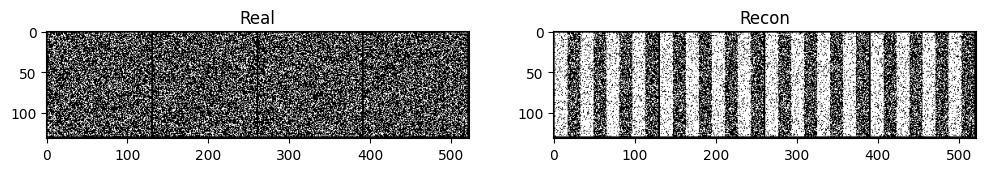

precision: 0.3019, recall: 0.8682, specificity: 0.1358, f1: 0.4480


In [21]:
#| eval: false
from midi_rae.core import PatchState, HierarchicalPatchState, EncoderOutput
import matplotlib.pyplot as plt

B, patch_size = 4, 16
img_real = (torch.rand(B, 1, 128, 128) > 0.7).float()  # fake sparse piano roll
recon = torch.randn(B, 65, patch_size**2)  # 64 patches + CLS, raw logits

mae_mask = torch.ones(65, dtype=torch.bool)
mae_mask[1::2] = False  # mask every other patch (skip CLS at 0)

enc_out = EncoderOutput(
    patches=HierarchicalPatchState(levels=[
        PatchState(emb=torch.randn(B,1,256), pos=torch.tensor([[-1,-1]]), non_empty=torch.ones(B,1,dtype=torch.bool), mae_mask=mae_mask[0:1]),
        PatchState(emb=torch.randn(B,64,256), pos=torch.zeros(64,2), non_empty=torch.ones(B,64,dtype=torch.bool), mae_mask=mae_mask[1:]),
    ]),
    full_pos=torch.zeros(65,2), full_non_empty=torch.ones(B,65,dtype=torch.bool), mae_mask=mae_mask,
)

grid_recon, grid_real, evals = viz_mae_recon(recon, img_real, enc_out=enc_out, epoch=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(grid_real.permute(1,2,0), cmap='gray'); ax1.set_title('Real')
ax2.imshow(grid_recon.permute(1,2,0), cmap='gray'); ax2.set_title('Recon')
plt.show()
print(', '.join(f"{k}: {v.item():.4f}" for k, v in evals.items()))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()